Load Data

In [1]:
import pandas as pd

data_train = pd.read_csv('Fake_New_Classification/train.csv', delimiter=";") # Load Train Datasets
data_test = pd.read_csv('Fake_New_Classification/test.csv', delimiter=";") # Load Test Datasets
data_eval = pd.read_csv('Fake_New_Classification/evaluation.csv', delimiter=";") # Load Evaluation Datasets

X_train = data_train['title'].values + data_train['text'].values # Create Train Data
X_test = data_test['title'].values + data_test['text'].values # Create Test Data
X_eval = data_eval['title'].values + data_eval['text'].values # Create Evaluation Data

Y_train = data_train['label'].values # Create Train Labels
Y_test = data_test['label'].values # Create Test Labels
Y_eval = data_eval['label'].values # Create Evaluation Labels

Preprocessing Data

In [3]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_len = 300

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Create Empty Dictionary
tokenizer.fit_on_texts(X_train) # Create Dictionary With 5000 words popular in train data

# Preprocessing Train Data

train_sequences = tokenizer.texts_to_sequences(X_train) # Mapping text to tokenizer
padded_train_sequence = pad_sequences(train_sequences, maxlen=max_len, padding="post") # Create sequences based on tokenizer

# Preprocessing Test Data

test_sequences = tokenizer.texts_to_sequences(X_test) # Mapping text to tokenizer
padded_test_sequence = pad_sequences(test_sequences, maxlen=max_len, padding="post") # Create sequences based on tokenizer

# Preprocessing Evaluate Data

eval_sequences = tokenizer.texts_to_sequences(X_eval) # Mapping text to tokenizer
padded_eval_sequence = pad_sequences(eval_sequences, maxlen=max_len, padding="post") # Create sequences based on tokenizer



Build And Train RNN simple Models

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    SimpleRNN(256, return_sequences=False, activation="tanh"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
history = model.fit(
    padded_train_sequence, Y_train, 
    validation_data=(padded_test_sequence, Y_test),
    batch_size=128, 
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
191/191 [==============================] - 230s 1s/step - loss: 0.5407 - accuracy: 0.7029 - val_loss: 0.3439 - val_accuracy: 0.8507
Epoch 2/10
191/191 [==============================] - 232s 1s/step - loss: 0.4612 - accuracy: 0.7781 - val_loss: 0.3466 - val_accuracy: 0.8306
Epoch 3/10
191/191 [==============================] - 229s 1s/step - loss: 0.3583 - accuracy: 0.8277 - val_loss: 0.4223 - val_accuracy: 0.8268
Epoch 4/10
191/191 [==============================] - 228s 1s/step - loss: 0.3065 - accuracy: 0.8895 - val_loss: 0.2543 - val_accuracy: 0.9231
Epoch 5/10
191/191 [==============================] - 236s 1s/step - loss: 0.3617 - accuracy: 0.8333 - val_loss: 0.3635 - val_accuracy: 0.8295
Epoch 6/10
191/191 [==============================] - 233s 1s/step - loss: 0.3647 - accuracy: 0.8176 - val_loss: 0.3966 - val_accuracy: 0.8281
Epoch 7/10
191/191 [==============================] - 232s 1s/step - loss: 0.3720 - accuracy: 0.8357 - val_loss: 0.3502 - val_accuracy: 0.8416

Evaluate Models

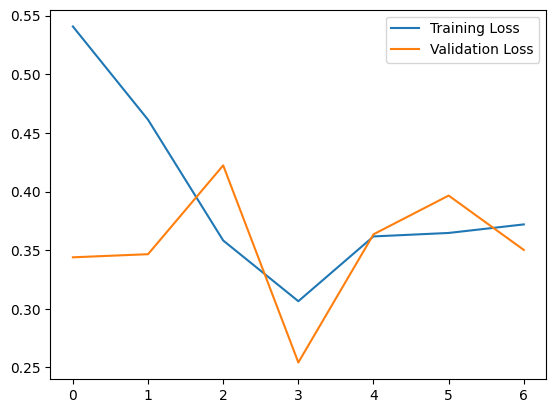

254/254 [==============================] - 24s 92ms/step

		Accuracy Model: 0.9181

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3803
           1       0.89      0.96      0.93      4314

    accuracy                           0.92      8117
   macro avg       0.92      0.91      0.92      8117
weighted avg       0.92      0.92      0.92      8117



In [13]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

loss = history.history['loss'] # History of Loss Function
val_loss = history.history['val_loss'] # value of Loss Function

# Show plot Loss - value-loss

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.show()

# Show accuracy model

predictions = (model.predict(padded_eval_sequence) > 0.5).astype("int32")
accuracy_model = accuracy_score(Y_eval, predictions) 
print(f"\n\t\tAccuracy Model: {accuracy_model:.4f}")

# Show Classification Report

print("\nClassification Report: ")
print(classification_report(Y_eval, predictions))


Save Models And Tokenizer

In [14]:
import pickle

model.save('fake_news_simpleRNN.h5') # Save model

with open('tokenizer_RNN.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save tokenizer

with open('history_simpleRNN.pkl', 'wb') as f:
    pickle.dump(history.history, f) # Save history